# Modelling Spread From Historical Data

# 1 - Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('data/EURUSD_Ticks_30.12.2024-30.12.2024.csv', parse_dates=['Gmt time'], dayfirst=True)
df = df.rename(columns={"Gmt time" : "Date"})
df

,Date,Ask,Bid,AskVolume,BidVolume
0,2024-12-30 00:00:01.473,1.04298,1.04297,0.90,0.90
1,2024-12-30 00:00:01.579,1.04299,1.04298,2.25,1.80
2,2024-12-30 00:00:01.682,1.04300,1.04299,2.25,0.90
3,2024-12-30 00:00:01.785,1.04303,1.04299,0.90,0.90
4,2024-12-30 00:00:05.383,1.04302,1.04299,0.90,2.25
...,...,...,...,...,...
79744,2024-12-30 23:59:44.482,1.04062,1.04057,0.90,7.74
79745,2024-12-30 23:59:55.733,1.04062,1.04058,0.90,0.90
79746,2024-12-30 23:59:57.849,1.04061,1.04058,0.90,0.90
79747,2024-12-30 23:59:58.005,1.04060,1.04057,0.90,0.45


# 2 - Historical Spread Distribution

In [3]:
df['Spread'] = df['Ask'] - df['Bid']
df

,Date,Ask,Bid,AskVolume,BidVolume,Spread
0,2024-12-30 00:00:01.473,1.04298,1.04297,0.90,0.90,0.00001
1,2024-12-30 00:00:01.579,1.04299,1.04298,2.25,1.80,0.00001
2,2024-12-30 00:00:01.682,1.04300,1.04299,2.25,0.90,0.00001
3,2024-12-30 00:00:01.785,1.04303,1.04299,0.90,0.90,0.00004
4,2024-12-30 00:00:05.383,1.04302,1.04299,0.90,2.25,0.00003
...,...,...,...,...,...,...
79744,2024-12-30 23:59:44.482,1.04062,1.04057,0.90,7.74,0.00005
79745,2024-12-30 23:59:55.733,1.04062,1.04058,0.90,0.90,0.00004
79746,2024-12-30 23:59:57.849,1.04061,1.04058,0.90,0.90,0.00003
79747,2024-12-30 23:59:58.005,1.04060,1.04057,0.90,0.45,0.00003


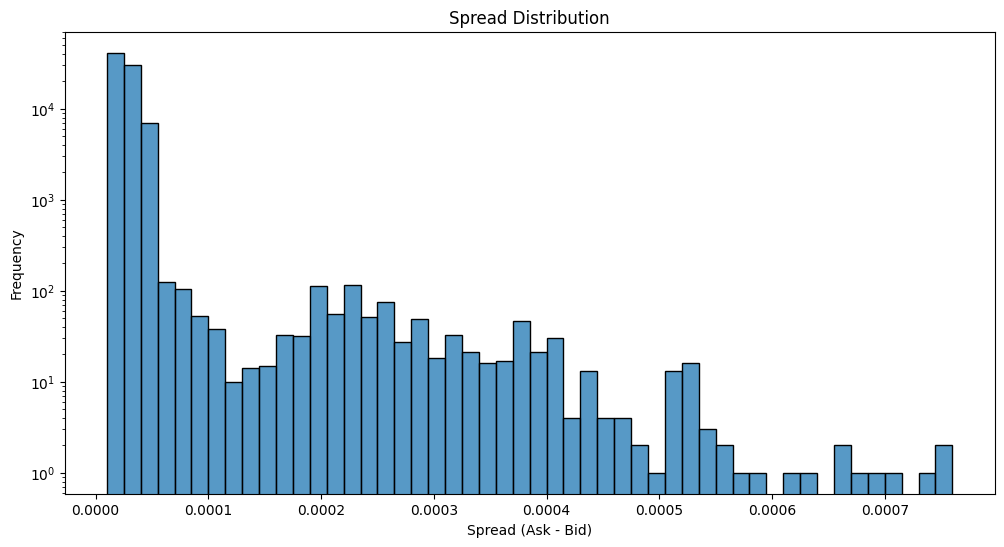

In [4]:
plt.figure(figsize=(12,6))
sns.histplot(df['Spread'], bins=50)
plt.yscale('log')
plt.title('Spread Distribution')
plt.xlabel('Spread (Ask - Bid)')
plt.ylabel('Frequency')
plt.show()

# 3 - Trying to fit the Spread in a distributiom

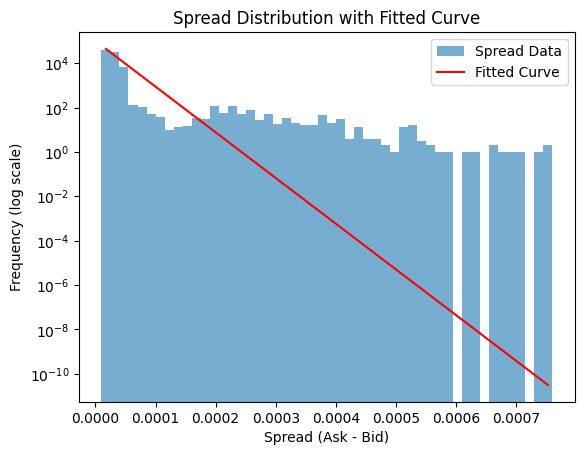

Fitted Curve: y = 100654.29 * exp(-47429.51 * x)


In [5]:
def Spread_fit(x, a, b):
    return a * np.exp(-b * x)

spread_data = df['Spread'].to_numpy()
bin_heights, bin_borders, _ = plt.hist(spread_data, bins=50, log=True, label='Spread Data', alpha=0.6)

bin_centers = (bin_borders[:-1] + bin_borders[1:]) / 2
params, covariance = curve_fit(Spread_fit, bin_centers, bin_heights, p0=[1, 1])

# params: An array of the optimal values for the parameters that minimize the residuals beteween the 
# provided function (spread_fit) and the data (bin_centers, bin_heights).
# covariance: The estimated covariance of params. The diagonals provide the variance of the parameter estimates

plt.plot(bin_centers, Spread_fit(bin_centers, *params), 'r-', label='Fitted Curve')
plt.xlabel('Spread (Ask - Bid)')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.title('Spread Distribution with Fitted Curve')
plt.legend()
plt.show()

spread_fit_equation = f"Fitted Curve: y = {params[0]:.2f} * exp(-{params[1]:.2f} * x)"
print(spread_fit_equation)

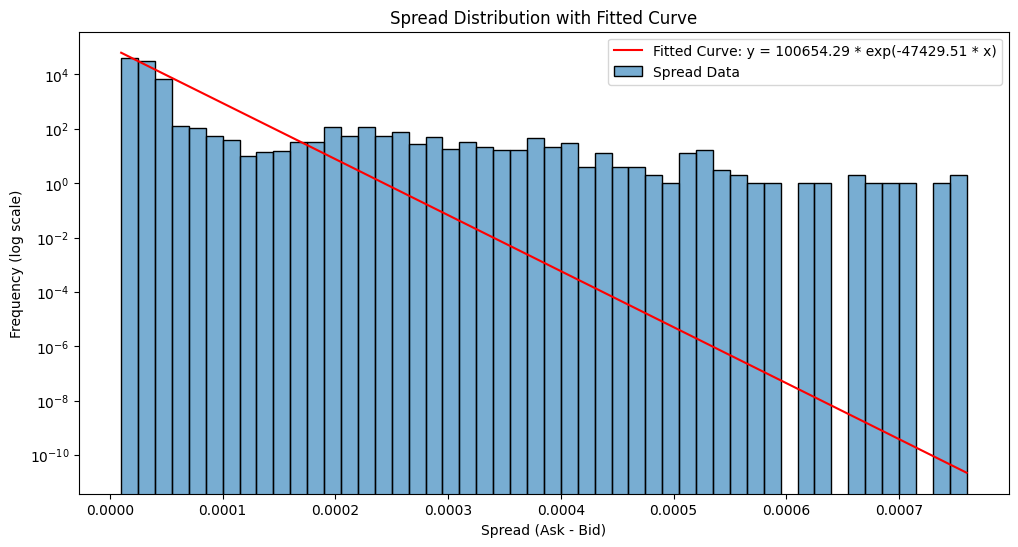

In [6]:
x = np.linspace(df['Spread'].min(), df['Spread'].max(), 100)
y = spread_fit_equation

plt.figure(figsize=(12,6))
sns.histplot(df['Spread'], bins=50, label='Spread Data', alpha=0.6)
plt.yscale('log')
plt.plot(x, Spread_fit(x, *params), 'r-', label=y)
plt.xlabel('Spread (Ask - Bid)')
plt.ylabel('Frequency (log scale)')
plt.title('Spread Distribution with Fitted Curve')
plt.legend()
plt.show()

# 4 - Generating Spread with the Von Neumann (Pure Numerical Approach)

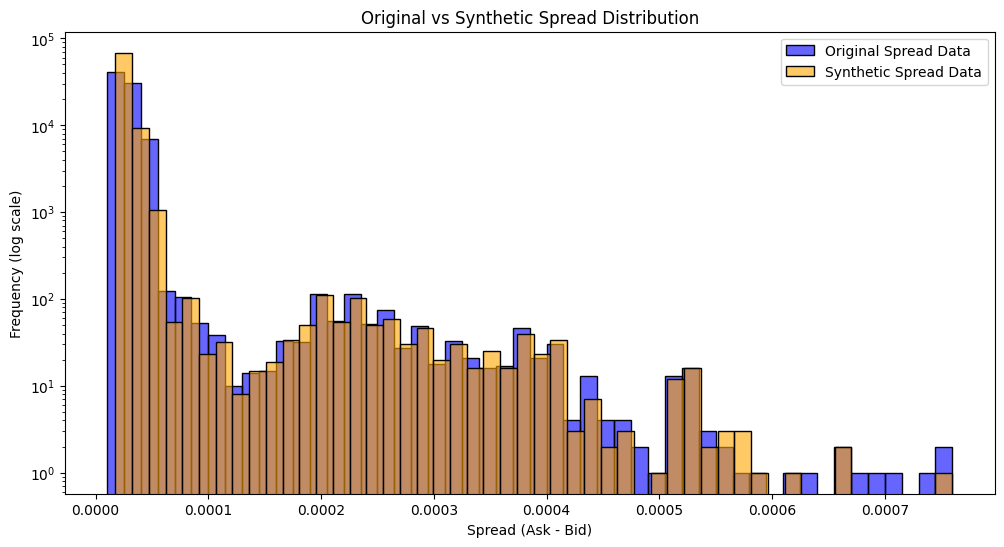

In [7]:
# Calculate the histogram of the spread data
hist_counts, bin_edges = np.histogram(df['Spread'], bins=100, density=True)

# Calculate the cumulative distribution function (CDF)
cdf = np.cumsum(hist_counts) * np.diff(bin_edges)

# Function to perform inverse transform sampling
def inverse_transform_sampling(cdf, bin_edges, num_samples):
    random_values = np.random.rand(num_samples)
    sampled_spreads = np.interp(random_values, cdf, bin_edges[1:])
    return sampled_spreads

# Generate synthetic spread data
num_samples = len(df)
synthetic_spreads = inverse_transform_sampling(cdf, bin_edges, num_samples)

# Plot the original and synthetic spread distributions
plt.figure(figsize=(12,6))
sns.histplot(df['Spread'], bins=50, label='Original Spread Data', color='blue', alpha=0.6)
sns.histplot(synthetic_spreads, bins=50, label='Synthetic Spread Data', color='orange', alpha=0.6)
plt.yscale('log')
plt.xlabel('Spread (Ask - Bid)')
plt.ylabel('Frequency (log scale)')
plt.title('Original vs Synthetic Spread Distribution')
plt.legend()
plt.show()

# 5 - Plotting the Cumulative for Clarity

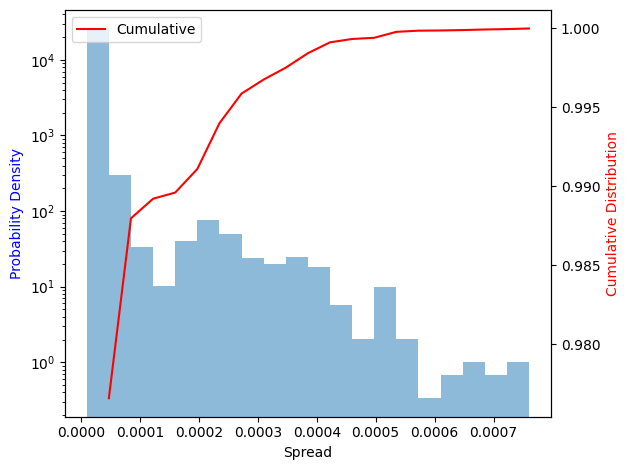

In [10]:
num_bins = 20

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot the histogram
ax1.hist(df["Spread"], bins=num_bins, density=True, log=True, alpha=0.5, label='Actual Spread')

# Compute and plot the cumulative distribution
cumulative = np.cumsum(np.histogram(df["Spread"], bins=num_bins, density=True)[0])
cumulative = cumulative / cumulative[-1]  # normalize the cumulative distribution
ax2.plot(np.histogram(df["Spread"], bins=num_bins)[1][1:], cumulative, 'r-', label='Cumulative')

ax1.set_xlabel('Spread')
ax1.set_ylabel('Probability Density', color='b')
ax2.set_ylabel('Cumulative Distribution', color='r')

fig.tight_layout()  # prevents the labels from getting cut off
plt.legend(loc='best')
plt.show()